In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Exploring the Data

##### Item Data:

In [4]:
## item_feature_id is hotel_country
## city_id is item_id
path_mike = "data/item_feature.csv"
path_renne = '/Users/Renne/Desktop/module3/Advanced_Machine_Learning/Kaggle/Kaggle_Zhiyi/item_feature.csv'
item = pd.read_csv(path_renne)
item.tail()

,item_id,item_feature_id
39896,39896,138
39897,39897,95
39898,39898,142
39899,39899,131
39900,39900,2


##### Training Data

In [7]:
path_mike = "data/training.csv"
path_renne = '/Users/Renne/Desktop/module3/Advanced_Machine_Learning/Kaggle/Kaggle_Zhiyi/training.csv'
train = pd.read_csv(path_renne)
train.head(),train.shape

(   user_id  item_id  context_feature_id
 0        0    28366                   2
 1        0    16109                   2
 2        0    11500                   3
 3        0    20750                   2
 4        0     8759                   2,
 (970245, 3))

In [4]:
print("train dataset duplicate rows: ", len(train[train.duplicated()]))

train dataset duplicate rows:  77874


In [5]:
# duplicate rows makes up about 8% of the data, will be removed from training data
train_unique = train.drop_duplicates().copy()
train_unique = train_unique.reset_index(drop=True)

In [6]:
#adding ratings for items present in training data (binary)
train_unique['ratings'] = 1
train_unique.head()

,user_id,item_id,context_feature_id,ratings
0,0,28366,2,1
1,0,16109,2,1
2,0,11500,3,1
3,0,20750,2,1
4,0,8759,2,1


##### Loading the testing data:

In [7]:
path_mike = "data/test_kaggle.csv"
path_renne = '/Users/Renne/Desktop/module3/Advanced_Machine_Learning/Kaggle/kaggle-the-art-of-coding/test_kaggle.csv'
test = pd.read_csv(path_mike)
test = test.drop(columns=['id']) # removing duplicate index id column
print("test data duplicate rows: ", len(test[test.duplicated()]))
test.head()

test data duplicate rows:  19470


,user_id,item_id,context_feature_id
0,4,16835,2
1,4,22590,3
2,4,1978,1
3,4,28916,1
4,4,14427,2


##### Checking for count of shared users/items with training and testing data

In [8]:
train_users, train_items = train.user_id.unique(), train.item_id.unique()
test_users, test_items = test.user_id.unique(), test.item_id.unique()

In [9]:
max(train_unique['item_id']),max(train_unique['user_id'])

(39900, 200152)

## Negative Sampling

Both functions were tried to see how it affects the model/error

In [10]:
# option1
def random_neg_sample1(ncols,nrows,n):
    # assgin 0 to each user
    zero_rating,zero_users = np.zeros(nrows),np.arange(nrows)
    zero_items = np.random.randint(low=0,high=ncols,size=nrows)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=nrows)
    each_zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    size = n - nrows

    # assgin 0 to others randomly
    zero_rating, zero_users = np.zeros(size),np.random.randint(low=0,high=nrows,size=size)
    zero_items = np.random.randint(low=0,high=ncols,size=size)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=size)
    other_zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    zero_sample = pd.concat([each_zero_sample,other_zero_sample])
    print(zero_sample.shape)
    return zero_sample    

# option2
def random_neg_sample2(ncols,nrows,n):
    # assgin random for whole
    zero_rating,zero_users = np.zeros(n),np.random.randint(low=0,high=nrows,size=n)
    zero_items = np.random.randint(low=0,high=ncols,size=n)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=n)
    zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    print(zero_sample.shape)
    return zero_sample

# option 3
def random_neg_sample3(ncols,nrows,n):
    # assgin 0 to each user
    zero_rating,zero_users = np.zeros(nrows),np.arange(nrows)
    zero_items = np.random.randint(low=0,high=ncols,size=nrows)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=nrows)
    user_zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    
    # assgin 0 to each item
    zero_rating,zero_items = np.zeros(ncols),np.arange(ncols)
    zero_users = np.random.randint(low=0,high=nrows,size=ncols)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=ncols)
    item_zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    size = n - nrows - ncols

    # assgin 0 to others randomly
    zero_rating, zero_users = np.zeros(size),np.random.randint(low=0,high=nrows,size=size)
    zero_items = np.random.randint(low=0,high=ncols,size=size)
    zero_content_feature_id = np.random.randint(low=0,high=4,size=size)
    other_zero_sample = pd.DataFrame({"user_id":zero_users,"item_id":zero_items,'context_feature_id':zero_content_feature_id,'ratings':zero_rating})
    zero_sample = pd.concat([item_zero_sample,user_zero_sample,other_zero_sample])
    print(zero_sample.shape)
    return zero_sample  

In [11]:
# n is the ratio of 0's to be populated.
n = int(len(train_unique)*1.2)
n #this value was changed many times to see how it affectes model training/errors

1070845

In [12]:
num_items = max(train_unique['item_id']) 
num_users = max(train_unique['user_id']) 
num_items,num_users 

(39900, 200152)

In [13]:
zero_df = random_neg_sample3(num_items,num_users,n) 

(1070845, 4)


In [14]:
zero_df.describe()

,user_id,item_id,context_feature_id,ratings
count,1.070845e+06,1.070845e+06,1.070845e+06,1070845.0
mean,1.000816e+05,1.994320e+04,1.499169e+00,0.0
std,5.779950e+04,1.152483e+04,1.118721e+00,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,4.998600e+04,9.968000e+03,0.000000e+00,0.0
50%,1.000850e+05,1.993300e+04,1.000000e+00,0.0
75%,1.501710e+05,2.992900e+04,3.000000e+00,0.0
max,2.001510e+05,3.989900e+04,3.000000e+00,0.0


In [15]:
# combine with train_unique, drop duplicate ('user_id', 'item_id', 'context_feature_id'), 
# if 3 columns value are same, keep the rating =1 row
df = pd.concat([train_unique,zero_df],axis=0)
print(df.shape)
df = df.drop_duplicates(subset=['user_id', 'item_id'],keep='first')
print(df.shape)

(1963216, 4)
(1933645, 4)


In [16]:
# merge 2 datasets
train_df = df.merge(item, on='item_id')
train_df.head()

,user_id,item_id,context_feature_id,ratings,item_feature_id
0,0,28366,2,1.0,7
1,1731,28366,1,1.0,7
2,10168,28366,2,1.0,7
3,18883,28366,1,1.0,7
4,19763,28366,2,1.0,7


## Train-valid splitting

In [17]:
ratings_one = train_df[train_df['ratings'] == 1.0]
ratings_zero = train_df[train_df['ratings'] == 0.0]
len(ratings_one), len(ratings_zero)

(862993, 1070652)

In [18]:
def sample_df(ratings_one,ratings_zero):
    msk = np.random.rand(len(ratings_one)) < 0.8
    train_one = ratings_one[msk].reset_index(drop=True)
    valid_one = ratings_one[~msk].reset_index(drop=True)
    
    msk = np.random.rand(len(ratings_zero)) < 0.8
    train_zero = ratings_zero[msk].sample(frac= len(ratings_one)/len(ratings_zero)).reset_index(drop=True)
    valid_zero = ratings_zero[~msk].sample(frac= len(ratings_one)/len(ratings_zero)).reset_index(drop=True)
    
    train = pd.concat([train_one,train_zero]).sample(frac=1).reset_index(drop=True)
    valid = pd.concat([valid_one,valid_zero]).sample(frac=1).reset_index(drop=True)
    return train,valid

train, valid = sample_df(ratings_one,ratings_zero) 

In [19]:
train,valid 

(         user_id  item_id  context_feature_id  ratings  item_feature_id
 0          86835     4265                   1      1.0              156
 1           5417    30521                   2      1.0              142
 2          39276    22759                   3      0.0              108
 3         125650     7458                   1      0.0              148
 4         150697    18414                   1      0.0               44
 ...          ...      ...                 ...      ...              ...
 1380895    10689    31481                   3      0.0               63
 1380896    21192    24921                   2      1.0              108
 1380897   154490    18452                   3      0.0               72
 1380898   132084     8628                   2      0.0              138
 1380899    10260    26352                   2      1.0               55
 
 [1380900 rows x 5 columns],
         user_id  item_id  context_feature_id  ratings  item_feature_id
 0         40869     

In [20]:
len(train[train['ratings'] == 1.0])/len(train[train['ratings'] == 0.0])

1.0015973352621181

In [21]:
len(valid[valid['ratings'] == 1.0])/len(valid[valid['ratings'] == 0.0])

0.9936335170485401

## Embedding Users and Items

In [22]:
#creating tensors from data for embedding
users_train = torch.LongTensor(train.user_id.values)
items_train = torch.LongTensor(train.item_id.values)
context_feature_train = torch.LongTensor(train.context_feature_id.values)
item_feature_train = torch.LongTensor(train.item_feature_id.values)
ratings_train = torch.FloatTensor(train.ratings.values)

users_valid = torch.LongTensor(valid.user_id.values)
items_valid = torch.LongTensor(valid.item_id.values)
context_feature_valid = torch.LongTensor(valid.context_feature_id.values)
item_feature_valid = torch.LongTensor(valid.item_feature_id.values)
ratings_valid = torch.FloatTensor(valid.ratings.values)

train_tensor = TensorDataset(users_train,items_train,ratings_train,context_feature_train,item_feature_train)
valid_tensor = TensorDataset(users_valid,items_valid,ratings_valid,context_feature_valid,item_feature_valid)

## Training Functions

In [23]:
def train_one_epoch(model, train_dl, optimizer):
    model.train()
    """ Trains the model for one epoch"""
    for u,i,r in train_dl:
        y_hat = model(u,i)
        
        loss = F.binary_cross_entropy(y_hat, r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
    return train_loss

In [24]:
def valid_metrics(model,dataloader):
    model.eval()
    losses = []
    y_hats = []
    ys = []
    
    for u,i,r in dataloader: 
        y_hat = model(u,i)
        y_hats.append(y_hat.detach().numpy())
        loss = F.binary_cross_entropy(y_hat, r)
        ys.append(r.numpy())
        losses.append(loss.item())
    
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_hats)
    roc_auc = roc_auc_score(ys,y_hats)
    return np.mean(losses), roc_auc

In [134]:
def training(model, ratings_one, ratings_zero, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train, valid = sample_df(ratings_one,ratings_zero)
    
    for i in range(epochs):             
        users_train = torch.LongTensor(train.user_id.values)
        items_train = torch.LongTensor(train.item_id.values)
        ratings_train = torch.FloatTensor(train.ratings.values)

        users_valid = torch.LongTensor(valid.user_id.values)
        items_valid = torch.LongTensor(valid.item_id.values)
        ratings_valid = torch.FloatTensor(valid.ratings.values)

        train_tensor = TensorDataset(users_train,items_train,ratings_train)
        valid_tensor = TensorDataset(users_valid,items_valid,ratings_valid)

        train_dl = DataLoader(train_tensor,batch_size=10000,shuffle=True)
        valid_dl = DataLoader(valid_tensor,batch_size=10000000,shuffle=True)
    
        train_loss = train_one_epoch(model, train_dl, optimizer)
        valid_loss, valid_acc = valid_metrics(model, valid_dl) 
        if i % 3 ==0:
            train, valid = sample_df(ratings_one,ratings_zero)
        print(f"{i+1:02d}: train loss {train_loss:.3f} valid loss {valid_loss:.3f} valid acc {valid_acc:.3f}") 
    return train_loss, valid_loss, valid_acc

## Matrix Factorization 

In [135]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, seed=23):
        super(MF, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        # init
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return torch.sigmoid((U*V).sum(1) +  b_u  + b_v)

#### Single Model Training

In [136]:
model = MF(num_users+1, num_items+1, emb_size=55)
training(model,ratings_one,ratings_zero, epochs=10, lr=0.1, wd=1e-6)

01: train loss 0.423 valid loss 0.453 valid acc 0.884
02: train loss 0.510 valid loss 0.497 valid acc 0.881
03: train loss 0.398 valid loss 0.457 valid acc 0.892
04: train loss 0.361 valid loss 0.413 valid acc 0.903
05: train loss 0.483 valid loss 0.447 valid acc 0.896
06: train loss 0.410 valid loss 0.482 valid acc 0.889
07: train loss 0.362 valid loss 0.470 valid acc 0.892
08: train loss 0.500 valid loss 0.525 valid acc 0.883
09: train loss 0.424 valid loss 0.522 valid acc 0.884
10: train loss 0.450 valid loss 0.463 valid acc 0.894


(0.4500303566455841, 0.46304982900619507, 0.8939215687394064)

In [137]:
#dynamic learning rate
training(model,ratings_one,ratings_zero, epochs=2, lr=0.01, wd=1e-6)

01: train loss 0.236 valid loss 0.263 valid acc 0.963
02: train loss 0.252 valid loss 0.226 valid acc 0.979


(0.2519039511680603, 0.22615773975849152, 0.9791527649285263)

In [132]:
#Looking at predictions for this model
u_test_ = torch.LongTensor(test.user_id.values)
v_test_ = torch.LongTensor(test.item_id.values)
y_hat_ = model(u_test_, v_test_)
test['rating']=y_hat_.detach().numpy()
table_ = {'id': test.index, 'rating': y_hat_.detach().numpy()}
result_ = pd.DataFrame(table_)
pos_res_test = result_[result_['rating'] > 0.5].sum() / len(result_)
_400_test = sum(test[test["item_id"] == 400]["rating"] > 0.5)
pos_res_test, _400_test

(id        83095.892261
 rating        0.333208
 dtype: float64,
 1282)

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'rating'}>]], dtype=object)

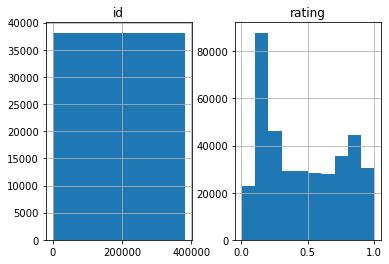

In [133]:
result_.hist()

In [68]:
#Saving results if desired 
result_.to_csv(f'past_results/results_MF_negsample3_A.csv', index=False)

#### Grid Search 

In [ ]:
#setting up data on GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# train.to(device)
# valid.to(device)
# tensor_item_fea.to(device)
# tensor_context_fea.to(device)

In [ ]:
def training_GPU(model, ratings_one, ratings_zero, epochs=10, lr=0.01, wd=1e-6, train_batch=100000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train, valid = sample_df(ratings_one,ratings_zero)
    
    for i in range(epochs):             
        users_train = torch.LongTensor(train.user_id.values).to(device)
        items_train = torch.LongTensor(train.item_id.values).to(device)
        context_feature_train = torch.LongTensor(train.context_feature_id.values).to(device)
        item_feature_train = torch.LongTensor(train.item_feature_id.values).to(device)
        ratings_train = torch.FloatTensor(train.ratings.values).to(device)

        users_valid = torch.LongTensor(valid.user_id.values).to(device)
        items_valid = torch.LongTensor(valid.item_id.values).to(device)
        context_feature_valid = torch.LongTensor(valid.context_feature_id.values).to(device)
        item_feature_valid = torch.LongTensor(valid.item_feature_id.values).to(device)
        ratings_valid = torch.FloatTensor(valid.ratings.values).to(device)

        train_tensor = TensorDataset(users_train,items_train,ratings_train,context_feature_train,item_feature_train)
        valid_tensor = TensorDataset(users_valid,items_valid,ratings_valid,context_feature_valid,item_feature_valid)

        train_dl = DataLoader(train_tensor,batch_size=train_batch,shuffle=True)
        valid_dl = DataLoader(valid_tensor,batch_size=10000000,shuffle=True)
    
        train_loss = train_one_epoch_GPU(model, train_dl, optimizer)
        valid_loss, valid_acc = valid_metrics_GPU(model, valid_dl) 
        if i % 3 ==0:
            train, valid = sample_df(ratings_one,ratings_zero)
        print(f"{i+1:02d}: train loss {train_loss:.3f} valid loss {valid_loss:.3f} valid acc {valid_acc:.3f}") 
    return train_loss, valid_loss, valid_acc

In [ ]:
def valid_metrics_GPU(model,dataloader):
    model.eval()
    losses = []
    y_hats = []
    ys = []
    
    for u,i,r,confea,itemfea in dataloader: 
        y_hat = model(u,i)
        y_hats.append(y_hat.cpu().detach().numpy())
        loss = F.binary_cross_entropy(y_hat, r)
        ys.append(r.cpu().numpy())
        losses.append(loss.item())
    
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_hats)
    roc_auc = roc_auc_score(ys,y_hats)
    return np.mean(losses), roc_auc

In [ ]:
def train_one_epoch_GPU(model, train_dl, optimizer):
    model.train()
    """ Trains the model for one epoch"""
    for u,i,r,confea,itemfea in train_dl:
        y_hat = model(u,i).cpu()
        loss = F.binary_cross_entropy(y_hat, r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
    return train_loss

In [ ]:
# defining possible testing ranges: 
#n = [1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35]
E1 = [8, 10, 12] # number of epochs at larger learning rate (lr1)
lr1 = [.12, .1, .08]
E2 = [1, 2, 3] # number of epochs at smaller learning rate (lr2)
lr2 = [.012,  .01, .008]
EB_size = [45, 55, 65]
w_decay = [1e-6]
n=1.2

In [ ]:
############### DO NOT RUN CELL ##################
# GRID SEARCH HAS ALRADY BEEN COMPLETED AND TAKES 
# A LONG TIME TO RUN; RESULTS WILL BE LOADED BELOW

# count = 44
# for e1 in E1:
#     for L1 in lr1:
#         for e2 in E2:
#             for L2 in lr2:
#                 for embs in EB_size:
#                     for WD in w_decay:
#                         if 0<len(results_df[(results_df['Epochs_1']==e1)&(results_df['lr1']==L1)&\
#                                                     (results_df['Epochs_2']==e2)&(results_df['lr2']==L2)&\
#                                                     (results_df['emb_size']==embs)&(results_df['weight_decay']==WD)]):
#                             pass
#                         model = MF(num_users+1, num_items+1, emb_size=embs).to(device)
#                         train_loss_, valid_loss_, valid_acc_ = training_GPU(model,ratings_one,ratings_zero, epochs=e1, lr=L1, wd=WD)
                        
#                         if e2>0:
#                             train_loss_, valid_loss_, valid_acc_ = training_GPU(model,ratings_one,ratings_zero, epochs=e2, lr=L2, wd=WD)

#                         # creating results
#                         u_test_ = torch.LongTensor(test.user_id.values).to(device)
#                         v_test_ = torch.LongTensor(test.item_id.values).to(device)
#                         y_hat_ = model(u_test_, v_test_)
#                         test['rating']=y_hat_.cpu().detach().numpy()
#                         table_ = {'id': test.index, 'rating': y_hat_.cpu().detach().numpy()}
#                         result_ = pd.DataFrame(table_)
#                         result_.to_csv(f'grid_search_results/results_model_{count}.csv', index=False)
#                         pos_res_test = result_[result_['rating'] > 0.5].sum() / len(result_)
#                         _400_test = sum(test[test["item_id"] == 400]["rating"] > 0.5)

#                         summary = { 'model':count,
#                             'n': n,
#                             'Epochs_1': e1,
#                             'lr1': L1,
#                             'Epochs_2': e2,
#                             'lr2': L2,
#                             'emb_size': embs,
#                             'weight_decay': WD,
#                             'train_loss': train_loss_,
#                             'val_loss': valid_loss_,
#                             'val_acc': valid_acc_,
#                             'pos_results': pos_res_test[1],
#                             'id_400': _400_test}

#                         print(summary)
#                         results_df = results_df.append(summary,ignore_index=True)
#                         count += 1

In [37]:
GR = pd.read_csv('grid_results.csv')
#del GR['Unnamed: 0']
#del GR['model']
GR.head()

,Unnamed: 0,n,Epochs_1,lr1,Epochs_2,lr2,emb_size,weight_decay,train_loss,val_loss,val_acc,pos_results,id_400,model
0,0,1.2,8.0,0.12,0.0,0.012,45.0,0.000000,0.043641,0.046764,0.998366,0.413625,1384.0,NaN
1,1,1.2,8.0,0.12,0.0,0.012,45.0,0.000001,0.255040,0.260267,0.968527,0.420315,1427.0,NaN
2,2,1.2,8.0,0.12,0.0,0.012,45.0,0.000010,0.443132,0.442652,0.917517,0.452113,1445.0,NaN
3,3,1.2,8.0,0.12,0.0,0.012,50.0,0.000000,0.045970,0.049601,0.998362,0.417342,1396.0,NaN
4,4,1.2,8.0,0.12,0.0,0.012,50.0,0.000001,0.255603,0.262247,0.967633,0.420946,1434.0,NaN


In [84]:
GR[GR['val_loss']<.18]

,Unnamed: 0,n,Epochs_1,lr1,Epochs_2,lr2,emb_size,weight_decay,train_loss,val_loss,val_acc,pos_results,id_400,model
0,0,1.2,8.0,0.12,0.0,0.012,45.0,0.0,0.043641,0.046764,0.998366,0.413625,1384.0,NaN
3,3,1.2,8.0,0.12,0.0,0.012,50.0,0.0,0.045970,0.049601,0.998362,0.417342,1396.0,NaN
6,6,1.2,8.0,0.12,0.0,0.012,55.0,0.0,0.051482,0.050015,0.998309,0.415687,1394.0,NaN
9,9,1.2,8.0,0.12,0.0,0.012,60.0,0.0,0.050469,0.052633,0.998263,0.419185,1386.0,NaN
12,12,1.2,8.0,0.12,0.0,0.012,65.0,0.0,0.054141,0.053423,0.998237,0.417074,1398.0,NaN
15,15,1.2,8.0,0.12,0.0,0.011,45.0,0.0,0.048480,0.046436,0.998348,0.417969,1378.0,NaN
18,18,1.2,8.0,0.12,0.0,0.011,50.0,0.0,0.044492,0.047827,0.998345,0.416995,1393.0,NaN
21,21,1.2,8.0,0.12,0.0,0.011,55.0,0.0,0.048062,0.051317,0.998283,0.414480,1379.0,NaN


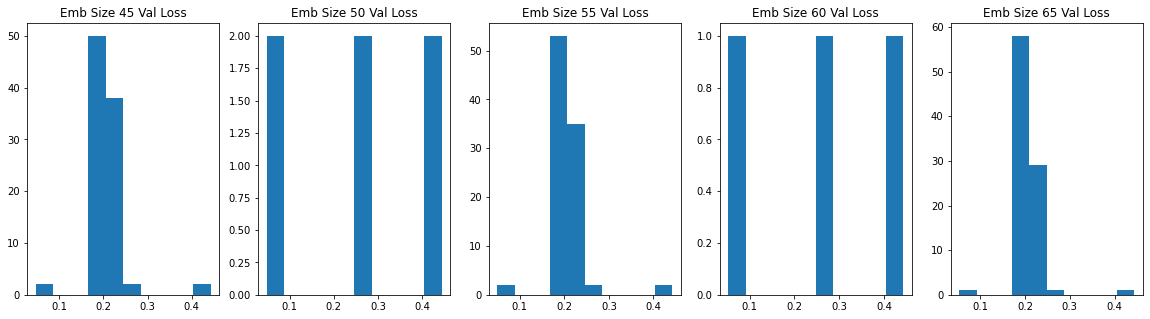

In [38]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
ax[0].hist(GR[GR['emb_size']==45]['val_loss'])
ax[0].set_title('Emb Size 45 Val Loss')
ax[1].hist(GR[GR['emb_size']==50]['val_loss'])
ax[1].set_title('Emb Size 50 Val Loss')
ax[2].hist(GR[GR['emb_size']==55]['val_loss'])
ax[2].set_title('Emb Size 55 Val Loss')
ax[3].hist(GR[GR['emb_size']==60]['val_loss'])
ax[3].set_title('Emb Size 60 Val Loss')
ax[4].hist(GR[GR['emb_size']==65]['val_loss'])
ax[4].set_title('Emb Size 65 Val Loss')
plt.show()

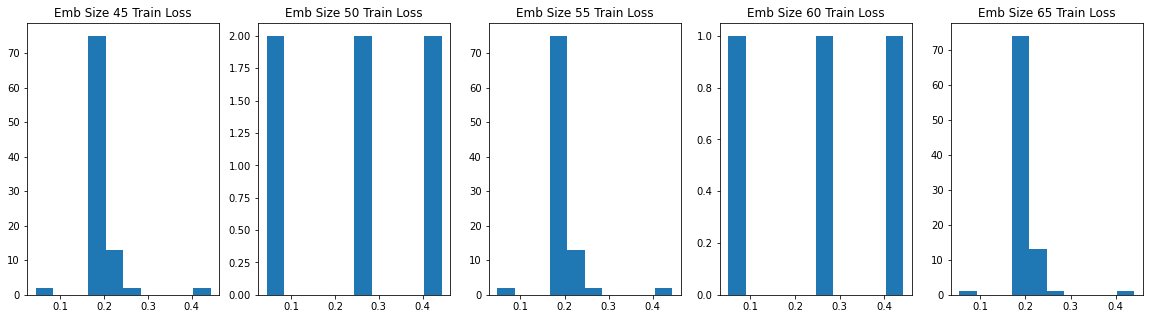

In [39]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
ax[0].hist(GR[GR['emb_size']==45]['train_loss'])
ax[0].set_title('Emb Size 45 Train Loss')
ax[1].hist(GR[GR['emb_size']==50]['train_loss'])
ax[1].set_title('Emb Size 50 Train Loss')
ax[2].hist(GR[GR['emb_size']==55]['train_loss'])
ax[2].set_title('Emb Size 55 Train Loss')
ax[3].hist(GR[GR['emb_size']==60]['train_loss'])
ax[3].set_title('Emb Size 60 Train Loss')
ax[4].hist(GR[GR['emb_size']==65]['train_loss'])
ax[4].set_title('Emb Size 65 Train Loss')
plt.show()

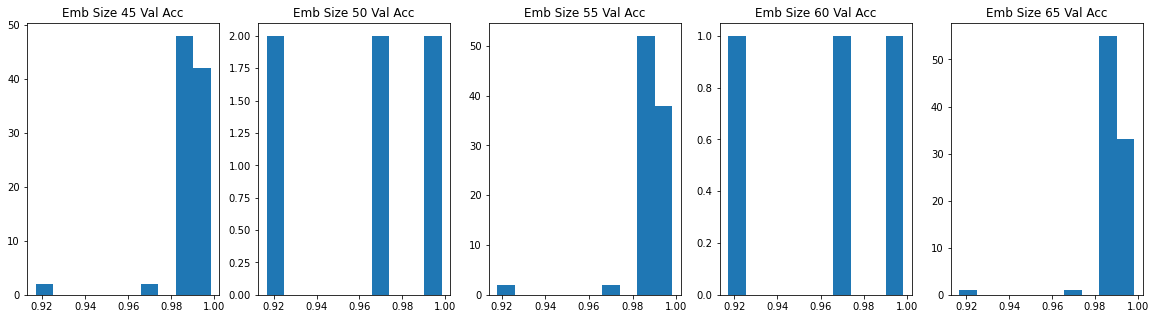

In [40]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
ax[0].hist(GR[GR['emb_size']==45]['val_acc'])
ax[0].set_title('Emb Size 45 Val Acc')
ax[1].hist(GR[GR['emb_size']==50]['val_acc'])
ax[1].set_title('Emb Size 50 Val Acc')
ax[2].hist(GR[GR['emb_size']==55]['val_acc'])
ax[2].set_title('Emb Size 55 Val Acc')
ax[3].hist(GR[GR['emb_size']==60]['val_acc'])
ax[3].set_title('Emb Size 60 Val Acc')
ax[4].hist(GR[GR['emb_size']==65]['val_acc'])
ax[4].set_title('Emb Size 65 Val Acc')
plt.show()

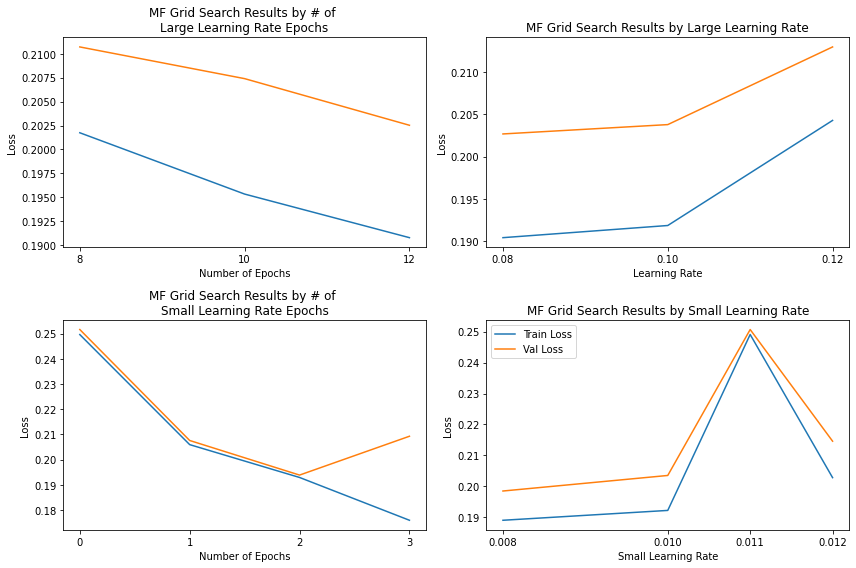

In [41]:
GR_E1 = GR.groupby('Epochs_1').mean()
GR_lr1 = GR.groupby('lr1').mean()
GR_E2 = GR.groupby('Epochs_2').mean()
GR_lr2 = GR.groupby('lr2').mean()
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(GR_E1['train_loss'], label='Train Loss')
ax[0,0].plot(GR_E1['val_loss'], label='Val Loss')
ax[0,0].set_title('MF Grid Search Results by # of \nLarge Learning Rate Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Number of Epochs')
ax[0,0].set_xticks(GR['Epochs_1'].unique())
ax[0,1].plot(GR_lr1['train_loss'], label='Train Loss')
ax[0,1].plot(GR_lr1['val_loss'], label='Val Loss')
ax[0,1].set_title('MF Grid Search Results by Large Learning Rate')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Learning Rate')
ax[0,1].set_xticks(GR['lr1'].unique())
ax[1,0].plot(GR_E2['train_loss'], label='Train Loss')
ax[1,0].plot(GR_E2['val_loss'], label='Val Loss')
ax[1,0].set_title('MF Grid Search Results by # of \nSmall Learning Rate Epochs')
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Number of Epochs')
ax[1,0].set_xticks(GR['Epochs_2'].unique())
ax[1,1].plot(GR_lr2['train_loss'], label='Train Loss')
ax[1,1].plot(GR_lr2['val_loss'], label='Val Loss')
ax[1,1].set_title('MF Grid Search Results by Small Learning Rate')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Small Learning Rate')
ax[1,1].set_xticks(GR['lr2'].unique())
plt.legend()
plt.tight_layout()
plt.show()

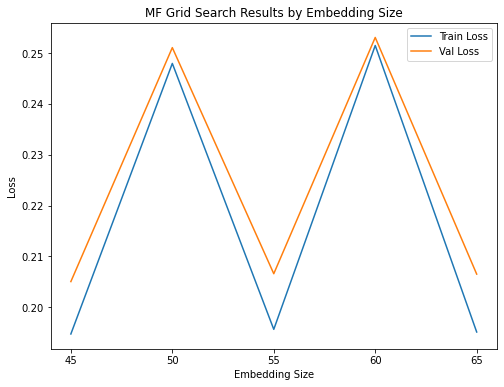

In [42]:
GR_EMB = GR.groupby('emb_size').mean()
x_lab = GR['emb_size'].unique()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(GR_EMB['train_loss'], label='Train Loss')
ax.plot(GR_EMB['val_loss'], label='Val Loss')
#ax.plot(GR_EMB['val_acc'], label='Val Acc')
ax.set_title('MF Grid Search Results by Embedding Size')
ax.set_ylabel('Loss')
ax.set_xlabel('Embedding Size')
ax.set_xticks(x_lab)
ax.legend()
plt.show()

## Ensemble of Best Models

In [117]:
# finding models to read in based off validation accuracy & error, 
# % of positive predictions, etc.
file_list = [f'past_results/results_agg_{i+1}.csv' for i in range(5)]
for i, file in enumerate(file_list):
    if i == 0:
        agg_df_5 = pd.read_csv(file)
        agg_df_5.columns = ['id', 'rating_1']
    else:
        new_df = pd.read_csv(file)
        new_df.columns = ['id', 'rating']
        agg_df_5[f'rating_{i+1}'] = new_df['rating']
agg_df_5.set_index('id', inplace=True)
agg_df_5.head()

,rating_1,rating_2,rating_3,rating_4,rating_5
id,,,,,
0,0.487153,0.497926,0.499369,0.510465,0.526118
1,0.292028,0.293428,0.295124,0.333843,0.329983
2,0.858137,0.858712,0.858946,0.862936,0.857550
3,0.207513,0.217998,0.218679,0.209864,0.213452
4,0.157313,0.178352,0.180264,0.167968,0.193258


In [118]:
agg_df_5['mean'] = agg_df_5.mean(axis=1)
agg_df_5.head()

,rating_1,rating_2,rating_3,rating_4,rating_5,mean
id,,,,,,
0,0.487153,0.497926,0.499369,0.510465,0.526118,0.504206
1,0.292028,0.293428,0.295124,0.333843,0.329983,0.308881
2,0.858137,0.858712,0.858946,0.862936,0.857550,0.859256
3,0.207513,0.217998,0.218679,0.209864,0.213452,0.213501
4,0.157313,0.178352,0.180264,0.167968,0.193258,0.175431


In [119]:
agg_results_avg5 = agg_df_5.reset_index()
agg_results_avg5 = agg_results_avg5[['id', 'mean']]
agg_results_avg5 = agg_results_avg5.rename(columns={'mean':'rating'})
agg_results_avg5.head()

,id,rating
0,0,0.504206
1,1,0.308881
2,2,0.859256
3,3,0.213501
4,4,0.175431


In [120]:
agg_results_avg5.to_csv(f'grid_search_results_MF/results_agg_agg.csv', index=False)

In [121]:
#now try the same thing with median instead
agg_df_5['median'] = agg_df_5.loc[:, agg_df_5.columns != 'mean'].median(axis=1)
agg_results_med5 = agg_df_5.reset_index()
agg_results_med5 = agg_results_med5[['id', 'median']]
agg_results_med5 = agg_results_med5.rename(columns={'median':'rating'})
agg_results_med5.to_csv(f'grid_search_results_MF/results_agg_med5.csv', index=False)

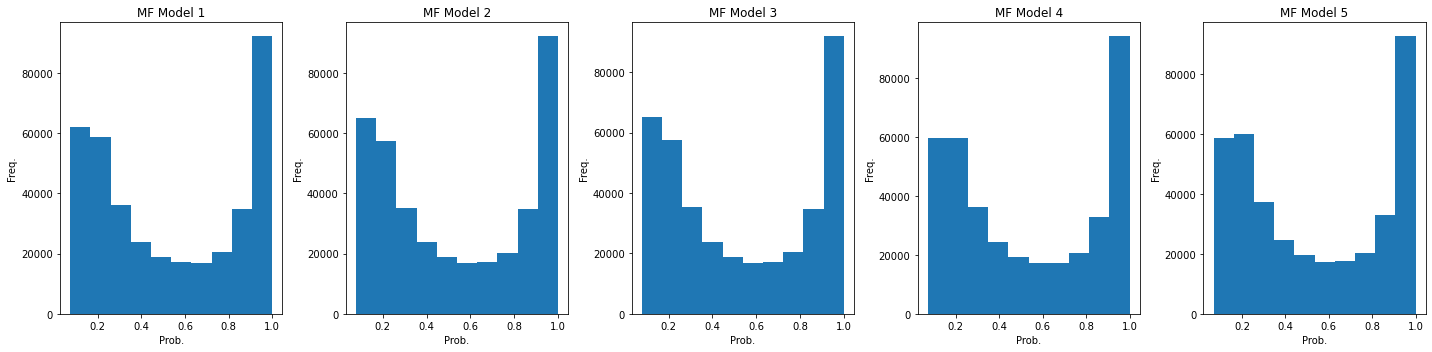

In [122]:
#creating some plots of our results
fig, ax = plt.subplots(1,5, figsize=(20, 5))
ax[0].hist(agg_df_5['rating_1'])
ax[0].set_title('MF Model 1')
ax[0].set_xlabel('Prob.')
ax[0].set_ylabel('Freq.')
ax[1].hist(agg_df_5['rating_2'])
ax[1].set_title('MF Model 2')
ax[1].set_xlabel('Prob.')
ax[1].set_ylabel('Freq.')
ax[2].hist(agg_df_5['rating_3'])
ax[2].set_title('MF Model 3')
ax[2].set_xlabel('Prob.')
ax[2].set_ylabel('Freq.')
ax[3].hist(agg_df_5['rating_4'])
ax[3].set_title('MF Model 4')
ax[3].set_xlabel('Prob.')
ax[3].set_ylabel('Freq.')
ax[4].hist(agg_df_5['rating_5'])
ax[4].set_title('MF Model 5')
ax[4].set_xlabel('Prob.')
ax[4].set_ylabel('Freq.')
plt.tight_layout()
plt.show()

Trying both iterations again but with top 10 results

In [75]:
file_list_10 = [f'best_results_agg/results-{i+1}.csv' for i in range(10)]
for i, file in enumerate(file_list_10):
    if i == 0:
        agg_df_10 = pd.read_csv(file)
        agg_df_10.columns = ['id', 'rating_1']
    else:
        new_df = pd.read_csv(file)
        new_df.columns = ['id', 'rating']
        agg_df_10[f'rating_{i+1}'] = new_df['rating']
agg_df_10.set_index('id', inplace=True)
agg_df_10['mean'] = agg_df_10.mean(axis=1)
agg_results_avg10 = agg_df_10.reset_index()
agg_results_avg10 = agg_results_avg10[['id', 'mean']]
agg_results_avg10 = agg_results_avg10.rename(columns={'mean':'rating'})
agg_results_avg10.to_csv(f'grid_search_results_MF/results_agg_avg10.csv', index=False)
agg_df_10.head()

,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,mean
id,,,,,,,,,,,
0,0.528544,0.523691,0.479160,0.478515,0.425856,0.584770,0.604719,0.386213,0.597669,0.439700,0.504884
1,0.404076,0.255890,0.341564,0.269647,0.188961,0.271373,0.264327,0.242933,0.321493,0.234793,0.279506
2,0.855672,0.859428,0.873710,0.853538,0.848336,0.863475,0.920573,0.821673,0.912891,0.810607,0.861990
3,0.273591,0.153312,0.202688,0.230903,0.177070,0.209142,0.238998,0.147650,0.221991,0.171781,0.202713
4,0.236260,0.150256,0.117388,0.153494,0.129168,0.265010,0.218249,0.167771,0.117985,0.176771,0.173235


In [ ]:
#now try the same thing with median instead
agg_df_10['median'] = agg_df_10.loc[:, df.columns != 'mean'].median(axis=1)
#agg_results_med10 = agg_df_10.reset_index()
agg_results_med10 = agg_df_10[['id', 'median']]
agg_results_med10 = agg_results_med10.rename(columns={'median':'rating'})
#agg_results_med10.to_csv(f'grid_search_results_MF/results_agg_med10.csv', index=False)

In [ ]:
# comparing the results via histogram 
fig, ax = plt.subplots(2,2, figsize=(12, 8))
ax[0,0].hist(agg_df_5['mean'])
ax[0,0].set_title('MF Mean - Top 5')
ax[0,0].set_xlabel('Prob.')
ax[0,0].set_ylabel('Freq.')
ax[0,1].hist(agg_df_5['median'])
ax[0,1].set_title('MF Median - Top 5')
ax[0,1].set_xlabel('Prob.')
ax[0,1].set_ylabel('Freq.')
ax[1,0].hist(agg_df10['mean'])
ax[1,0].set_title('MF Mean - Top 10')
ax[1,0].set_xlabel('Prob.')
ax[1,0].set_ylabel('Freq.')
ax[1,1].hist(agg_df10['median'])
ax[1,1].set_title('MF Median - Top 10')
ax[1,1].set_xlabel('Prob.')
ax[1,1].set_ylabel('Freq.')
plt.tight_layout()
plt.show()

In [ ]:
file_list = [f'best_results_agg/results-{i+1}.csv' for i in range(3)]
for i, file in enumerate(file_list):
    if i == 0:
        agg_df_3 = pd.read_csv(file)
        agg_df_3.columns = ['id', 'rating_1']
    else:
        new_df = pd.read_csv(file)
        new_df.columns = ['id', 'rating']
        agg_df_3[f'rating_{i+1}'] = new_df['rating']
agg_df_3.set_index('id', inplace=True)
agg_df_3.head()

In [ ]:
agg_df_3['mean'] = agg_df_3.mean(axis=1)
agg_results_avg3 = agg_df_3.reset_index()
agg_results_avg3 = agg_results_avg3[['id', 'mean']]
agg_results_avg3 = agg_results_avg3.rename(columns={'mean':'rating'})
agg_results_avg3.head()

In [ ]:
agg_results_avg3.to_csv(f'grid_search_results_MF/results_agg_avg3.csv', index=False)

## NN Model

In [93]:
class NN(nn.Module):
    def __init__(self, num_users, num_items,emb_size=55, seed=1, hidden=4, drop=.8):
        super(NN, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        ## can change the hidden layer
        self.linear1 = nn.Linear(3,hidden)
        self.linear2 = nn.Linear(hidden,1)
        self.con = tensor_context_fea
        self.item = tensor_item_fea
         
        # add dropout rate
        self.drop = nn.Dropout(drop)
        # init
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        # add neural network part
        # add context_feature and item_feature tensor as the consist features
        x = torch.cat((((U*V).sum(1)+b_u+b_v).unsqueeze(0),self.con[v].unsqueeze(0), self.item[v].unsqueeze(0)), 0)       
        x = torch.transpose(x,0,1)
        x = self.linear1(x)
        x = self.drop(F.relu(x))
        x = self.linear2(x)
        return torch.sigmoid(x).squeeze(1) 

#### transfer item_feature_id to tensor

In [94]:
item_fea = dict(zip(item.item_id,item.item_feature_id))
array_item_fea = np.array(list(item_fea.values()), dtype=float)
array_item_fea

array([139.,  55.,  11., ..., 142., 131.,   2.])

In [95]:
# check whether we have missed anything
set(list(range(max(train_unique['item_id'])+1)))-set(item_fea.keys())

set()

In [96]:
# transfer to tensor
tensor_item_fea = torch.LongTensor(array_item_fea)
tensor_item_fea.shape

torch.Size([39901])

#### transfer context_feature_id to tensor

In [97]:
## combine the train and test first, otherwise the size will not consist
new_df = pd.concat([train_unique, test])

context_dict = dict(zip(new_df.item_id, new_df.context_feature_id))

array_context_fea = np.array(list(context_dict.values()), dtype=float)
tensor_context_fea = torch.LongTensor(array_context_fea)
tensor_context_fea.shape

torch.Size([39901])

#### Resetting training data for NN Model

In [98]:
# n is the ratio of 0's to be populated.
n = int(len(train_unique)*1.2)
n #this value was changed many times to see how it affectes model training/errors

1070845

In [99]:
num_items = max(train_unique['item_id']) 
num_users = max(train_unique['user_id']) 
num_items,num_users 

(39900, 200152)

In [100]:
zero_df = random_neg_sample1(num_items,num_users,n) 

(1070845, 4)


In [101]:
zero_df.describe()

,user_id,item_id,context_feature_id,ratings
count,1.070845e+06,1.070845e+06,1.070845e+06,1070845.0
mean,1.001371e+05,1.993331e+04,1.498973e+00,0.0
std,5.775795e+04,1.152442e+04,1.117454e+00,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,5.022300e+04,9.935000e+03,0.000000e+00,0.0
50%,1.002040e+05,1.992400e+04,2.000000e+00,0.0
75%,1.501740e+05,2.992000e+04,2.000000e+00,0.0
max,2.001510e+05,3.989900e+04,3.000000e+00,0.0


In [102]:
# combine with train_unique, drop duplicate ('user_id', 'item_id', 'context_feature_id'), 
# if 3 columns value are same, keep the rating =1 row
df = pd.concat([train_unique,zero_df],axis=0)
print(df.shape)
df = df.drop_duplicates(subset=['user_id', 'item_id'],keep='first')
print(df.shape)

(1963216, 4)
(1933651, 4)


In [103]:
# merge 2 datasets
train_df = df.merge(item, on='item_id')
train_df.head()

,user_id,item_id,context_feature_id,ratings,item_feature_id
0,0,28366,2,1.0,7
1,1731,28366,1,1.0,7
2,10168,28366,2,1.0,7
3,18883,28366,1,1.0,7
4,19763,28366,2,1.0,7


In [105]:
# change the parameter i.e. emb_size, lr, wd
model = NN(num_users+1, num_items+1, emb_size=55)
training(model,ratings_one,ratings_zero, epochs=5, lr=0.1, wd=1e-6)

01: train loss 0.693 valid loss 0.693 valid acc 0.511
02: train loss 0.692 valid loss 0.690 valid acc 0.517
03: train loss 0.692 valid loss 0.689 valid acc 0.518
04: train loss 0.691 valid loss 0.690 valid acc 0.519
05: train loss 0.691 valid loss 0.689 valid acc 0.520


(0.6908925771713257, 0.6887662410736084, 0.5200528029894609)

In [ ]:
training(model,ratings_one,ratings_zero, epochs=2, lr=0.0001, wd=1e-6) ## train loss 0.18, valid loss 0.22

In [ ]:
u_test=torch.LongTensor(test.user_id.values)
v_test=torch.LongTensor(test.item_id.values)
y_hat=model(u_test,v_test)
test['rating']=y_hat.detach().numpy()
table = {'id':test.index, 'rating':y_hat.detach().numpy()}
results = pd.DataFrame(table)
results[results['rating']>0.5].sum()/len(results)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(results['rating'])
ax.set_title('Single NN Model Results')
ax.set_xlabel('Prob.')
ax.set_ylabel('Freq.')
plt.show()

In [ ]:
u_test=torch.LongTensor(test.user_id.values)
v_test=torch.LongTensor(test.item_id.values)
y_hat=model(u_test,v_test)
table = {'id':test.index, 'rating':y_hat.detach().numpy()}
results = pd.DataFrame(table)
results[results['rating']>0.5].sum()/len(results)
# sum(test[test["item_id"]==400]["rating"]>0.5)

In [ ]:
test['rating']= results['rating']

In [ ]:
sum(test[test["item_id"]==400]["rating"]>0.5)

In [ ]:
results.describe()

In [ ]:
#to csv
results.to_csv('results_NN.csv', index = False)

#### Grid Search NN

In [ ]:
try:
    resultsNN_df = pd.read_csv('grid_results_NN.csv')
    resultsNN_df = resultsNN_df.set_index('model')
except:
    resultsNN_df = pd.DataFrame(columns=['model', 'n', 'Epochs_1', 'lr1', 'DropOut', 'emb_size', 'Hidden',
                                       'train_loss', 'val_loss', 'val_acc', 'pos_results', 'id_400'])

    resultsNN_df['n'] = 1.2
    resultsNN_df = resultsNN_df.set_index('model')
#resultsNN_df = resultsNN_df.rename(columns={'Unnamed: 0':'model'}).set_index('model')
resultsNN_df.head()

In [ ]:
E1 = [8, 10] # number of epochs at larger learning rate (lr1)
lr1 = [.01, .005]
dropout = [.8, .9] 
EB_size = [45, 55, 65]
HIDDEN = [16, 64, 256]
n=1.2

In [ ]:
############### DO NOT RUN CELL ##################
# GRID SEARCH HAS ALRADY BEEN COMPLETED AND TAKES 
# A LONG TIME TO RUN; RESULTS WILL BE LOADED BELOW

# count = 1
# for e1 in E1:
#     for L1 in lr1:
#         for D in dropout:
#             for embs in EB_size:
#                 for H in HIDDEN:
#                     if 0<len(resultsNN_df[(resultsNN_df['Epochs_1']==e1)&(resultsNN_df['lr1']==L1)&\
#                                                 (resultsNN_df['DropOut']==D)&\
#                                                 (resultsNN_df['emb_size']==embs)&(resultsNN_df['Hidden']==H)]):
#                         pass
#                     model = NN(num_users+1, num_items+1, emb_size=embs, hidden=H, drop=D)
#                     train_loss_, valid_loss_, valid_acc_ = training(model,ratings_one,ratings_zero, epochs=e1, lr=L1)

#                     train_loss_, valid_loss_, valid_acc_ = training(model,ratings_one,ratings_zero, epochs=3, lr=.0001)

#                     # creating results
#                     u_test_ = torch.LongTensor(test.user_id.values)
#                     v_test_ = torch.LongTensor(test.item_id.values)
#                     y_hat_ = model(u_test_, v_test_)
#                     test['rating']=y_hat_.detach().numpy()
#                     table_ = {'id': test.index, 'rating': y_hat_.detach().numpy()}
#                     result_ = pd.DataFrame(table_)
#                     result_.to_csv(f'grid_search_results_NN/results_model_{count}.csv', index=False)
#                     pos_res_test = result_[result_['rating'] > 0.5].sum() / len(result_)
#                     _400_test = sum(test[test["item_id"] == 400]["rating"] > 0.5)

#                     summary = { 'model':count,
#                         'n': n,
#                         'Epochs_1': e1,
#                         'lr1': L1,
#                         'DropOut': D,
#                         'emb_size': embs,
#                         'Hidden': H,
#                         'train_loss': train_loss_,
#                         'val_loss': valid_loss_,
#                         'val_acc': valid_acc_,
#                         'pos_results': pos_res_test[1],
#                         'id_400': _400_test}

#                     print(summary)
#                     resultsNN_df = resultsNN_df.append(summary,ignore_index=True)
#                     count += 1

In [ ]:
resultsNN_df.to_csv('grid_results_NN.csv', index ='model')
NN_GR = pd.read_csv('grid_results_NN.csv')

#### Comparing the results visually

In [ ]:
NN_E1 = NN_GR.groupby('Epochs_1').mean()
NN_lr1 = NN_GR.groupby('lr1').mean()
NN_hid = NN_GR.groupby('Hidden').mean()
NN_drop= NN_GR.groupby('DropOut').mean()
x_lab = NN_GR['Epochs_1'].unique()
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(NN_E1['train_loss'], label='Train Loss')
ax[0,0].plot(NN_E1['val_loss'], label='Val Loss')
ax[0,0].set_title('NN Grid Search Results by # of \nLarge Learning Rate Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Number of Epochs')
ax[0,0].set_xticks(NN_GR['Epochs_1'].unique())
ax[0,1].plot(NN_lr1['train_loss'], label='Train Loss')
ax[0,1].plot(NN_lr1['val_loss'], label='Val Loss')
ax[0,1].set_title('NN Grid Search Results by Learning Rate')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Learning Rate')
ax[0,1].set_xticks(NN_GR['lr1'].unique())
ax[1,0].plot(NN_hid['train_loss'], label='Train Loss')
ax[1,0].plot(NN_hid['val_loss'], label='Val Loss')
ax[1,0].set_title('NN Grid Search Results by # of Hidden Layers')
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Hidden Layer Count')
ax[1,0].set_xticks(NN_GR['Hidden'].unique())
ax[1,1].plot(NN_drop['train_loss'], label='Train Loss')
ax[1,1].plot(NN_drop['val_loss'], label='Val Loss')
ax[1,1].set_title('NN Grid Search Results by Drop Out')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Drop Out')
ax[1,1].set_xticks(NN_GR['DropOut'].unique())
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
NN_EMB = NN_GR.groupby('emb_size').mean()
x_lab = NN_GR['emb_size'].unique()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(NN_EMB['train_loss'], label='Train Loss')
ax.plot(NN_EMB['val_loss'], label='Val Loss')
#ax.plot(GR_EMB['val_acc'], label='Val Acc')
ax.set_title('NN Grid Search Results by Embedding Size')
ax.set_ylabel('Loss')
ax.set_xlabel('Embedding Size')
ax.set_xticks(x_lab)
ax.legend()
plt.show()

## Trying to Combine MF and NN Models

In [ ]:
class NN(nn.Module):
    def __init__(self, num_users, num_items,emb_size=100, seed=23, hidden=16, drop=.8):
        super(NN, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        ## can change the hidden layer
        self.linear1 = nn.Linear(3,hidden)
        self.linear2 = nn.Linear(hidden,1)
        self.con = tensor_context_fea
        self.item = tensor_item_fea
         
        # add dropout rate
        self.drop = nn.Dropout(drop)
        # init
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        # add neural network part
        # add context_feature and item_feature tensor as the consist features
        x = torch.cat((((U*V).sum(1)+b_u+b_v).unsqueeze(0),self.con[v].unsqueeze(0), self.item[v].unsqueeze(0)), 0)       
        x = torch.transpose(x,0,1)
        x = self.linear1(x)
        x = self.drop(F.relu(x))
        x = self.linear2(x)
        return torch.sigmoid(x).squeeze(1) 